In [166]:
import numpy as np
import h5py
import Analysis
from copy import deepcopy

def AddFitMetadata(path, h5_path, A, extra_dict=None):
        h5 = h5py.File(path)
        
        try: 
            h5.create_group(h5_path)
        except:
            del h5[h5_path]
            h5.create_group(h5_path)
            

        fa = h5[h5_path].attrs
        fit = A.SaveFit()

        for key, val in fit.items():
            if key not in ['Data', 'energies', 'loglike', 'PSC']:
                fa.create('flux_'+key,val['flux'])
                fa.create('fluxunc_'+key,val['fluxunc'])        

        fa.create('loglike_total',np.sum(A.loglike))
        fa.create('loglike',A.loglike)
        fa.create('energies',A.central_energies)
        fa.create('bins', A.bin_edges)
        fa.create('irf', A.irf)
        fa.create('evclass', A.evclass)
        fa.create('convtype', A.convtype)
        fa.create('phfile', A.phfile)
        fa.create('tag', A.tag)

        if extra_dict is not None:
            for key, val in extra_dict.items():
                if key == 'residual':
                    try:
                        del h5[h5_path+'/residual']
                    except: 
                        pass

                    h5.create_dataset(h5_path+'/residual', data=val, dtype='float32')
                    print 'Saving new residual... Shape = ', val.shape
                else:
                    fa.create(key, val)
        h5.close()

def LoadModel(basedir, galprop_tag):
    # Load various diffuse models and run fits.
    print 'Running Analysis for model', galprop_tag
    
    
    #A = Analysis.Analysis(tag='P8R2_PSF3_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    A = Analysis.Analysis(tag='P8R2_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    
    A.GenSquareMask(l_range=[-40.,40.], b_range=[-40.,40.], plane_mask=2.)
    A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
    # Load 2FGL 
    A.AddPointSourceTemplate(fixNorm=True,pscmap='PSC_' + A.tag + '_fgl3_with_ext.npy')
    A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1)
    A.AddIsotropicTemplate(fixNorm=False, fixSpectrum=False) # External chi^2 used to fix normalization within uncertainties
    
    A.AddFermiBubbleTemplate(template_file='./bubble_templates_diskcut30.0.fits', 
                         spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)
    
    
    A.AddHDF5Template(hdf5file=basedir +'/'+ galprop_tag+'.hdf5',verbosity=1, multiplier=1., bremsfrac=1.25, 
                  E_subsample=2, fixSpectrum=False, separate_ics=False)
    return A



In [175]:
#A = LoadModel('/data/GCE_sys/new','mod_s_42_XCO_P8_PSF3')
A = LoadModel('/data/GCE_sys/new/iter1/','mod_s_42_XCO_P8')
#A = LoadModel('/data/GCE_sys/new/iter1/','mod_s_46_XCO_P8')


Running Analysis for model mod_s_42_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...


In [155]:
AR_temp_single = np.load('./aquila_rift_template.npy').astype(np.float32).clip(0,1e20)
AR_template = np.zeros((A.n_bins,len(AR_temp_single)))

for i in range(A.n_bins):
    AR_template[i] = AR_temp_single/np.max(AR_temp_single)*1e-8/A.central_energies[i]
A.AddTemplate('AqRift',AR_template)
    
for i in range(A.n_bins):
    A.templateList['AqRift'].healpixCube[i] = A.templateList['AqRift'].healpixCube[i].clip(0)

In [168]:
A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
              r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)

# A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=.75, 
#                r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)

#A.DeleteTemplate('AqRift')
# for i in range(A.n_bins):    
#     print 'AQ', np.min(A.templateList['AqRift'].healpixCube[i].clip(0)), np.max(A.templateList['AqRift'].healpixCube[i])
#     print 'ICS', np.min(A.templateList['ICS'].healpixCube[i]), np.min(A.templateList['ICS'].healpixCube[i])
    



array([  8.28616975e-16,   0.00000000e+00,   0.00000000e+00, ...,
         0.00000000e+00,   0.00000000e+00,   8.28616975e-16])

In [177]:
A.ResetFit()    

A.DeleteTemplate('DM')

for key, template in A.templateList.items():
    if key not in ['DM','AqRift']:
        template.limits=[None, None]
        
    if key in ['DM','AqRift']:
        template.limits=[-10,10]


A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]


Masking completed in 2.5337e-01 s
Write likelihood tempfile to  /tmp/tmpdM4bFK
Code generation completed in 9.8681e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -1490971.26112 
 TOTAL NCALL = 103 
 NCALLS = 103 
 
 
 EDM = 0.00105812086425 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_0,6.667327e-01,7.593068e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_0,5.272462e-02,4.162869e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_0,2.232546e+00,2.258354e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_0,1.152974e+00,4.721316e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.46e-01 s
Masking completed in 1.6418e-01 s
Write likelihood tempfile to  /tmp/tmpN2yBim
Code generation completed in 9.3603e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -1141371.20553 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 9.24183686243e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_1,6.515838e-01,8.238417e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_1,1.363415e-01,4.217064e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_1,2.200138e+00,2.505998e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_1,1.179334e+00,5.053747e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.70e-01 s
Masking completed in 1.6343e-01 s
Write likelihood tempfile to  /tmp/tmp77SWjA
Code generation completed in 9.5201e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -860098.806494 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 0.00115688069891 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_2,6.704043e-01,9.155717e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_2,2.600071e-01,4.320125e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_2,2.090977e+00,2.731871e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_2,1.212522e+00,5.522641e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.36e-01 s
Masking completed in 1.6417e-01 s
Write likelihood tempfile to  /tmp/tmpszB91X
Code generation completed in 9.3913e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -639525.604688 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 0.000411132816684 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_3,6.646687e-01,9.943163e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_3,3.903456e-01,4.719737e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_3,2.049040e+00,2.979414e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_3,1.216757e+00,5.937395e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.44e-01 s
Masking completed in 1.6369e-01 s
Write likelihood tempfile to  /tmp/tmp7HuLwH
Code generation completed in 9.1410e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -606154.2321 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 0.000583776982996 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_4,6.631127e-01,1.004842e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_4,3.519001e-01,4.472869e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_4,1.982395e+00,2.968253e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_4,1.222576e+00,5.960445e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.34e-01 s
Masking completed in 1.6381e-01 s
Write likelihood tempfile to  /tmp/tmpcNDo6O
Code generation completed in 9.1410e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -591333.875914 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 5.59050583577e-07 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_5,6.756496e-01,1.032786e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_5,2.988566e-01,4.214742e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_5,1.875874e+00,2.917462e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_5,1.253179e+00,6.049064e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.33e-01 s
Masking completed in 1.6411e-01 s
Write likelihood tempfile to  /tmp/tmpi6nbzG
Code generation completed in 9.3412e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -559648.878489 
 TOTAL NCALL = 103 
 NCALLS = 103 
 
 
 EDM = 1.84283388679e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_6,6.289922e-01,1.023062e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_6,4.772168e-01,4.171583e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_6,1.820923e+00,2.872229e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_6,1.237458e+00,5.929532e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.46e-01 s
Masking completed in 1.6452e-01 s
Write likelihood tempfile to  /tmp/tmpP2Pe6J
Code generation completed in 9.6798e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -512055.398251 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 0.000775740274205 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_7,6.354623e-01,1.072765e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_7,5.162247e-01,3.984762e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_7,1.820374e+00,3.009215e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_7,1.262693e+00,6.101964e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.31e-01 s
Masking completed in 1.6373e-01 s
Write likelihood tempfile to  /tmp/tmp7jsN9q
Code generation completed in 9.1100e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -464015.821561 
 TOTAL NCALL = 104 
 NCALLS = 104 
 
 
 EDM = 5.23360970178e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_8,6.526285e-01,1.065834e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_8,5.804475e-01,3.939621e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_8,1.744293e+00,3.163821e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_8,1.221878e+00,6.058042e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.54e-01 s
Masking completed in 1.6370e-01 s
Write likelihood tempfile to  /tmp/tmplEPkWv
Code generation completed in 9.3508e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -405871.393203 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 0.000559360746433 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_9,6.203271e-01,1.104511e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_9,6.347098e-01,4.117497e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_9,1.833223e+00,3.386549e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_9,1.254484e+00,6.309414e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.31e-01 s
Masking completed in 3.3380e-01 s
Write likelihood tempfile to  /tmp/tmpEIFMLf
Code generation completed in 9.3389e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -356002.983369 
 TOTAL NCALL = 107 
 NCALLS = 107 
 
 
 EDM = 6.55760087109e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_10,6.213192e-01,1.107553e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_10,6.792064e-01,3.836330e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_10,1.893812e+00,3.701631e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_10,1.237956e+00,6.398603e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.69e-01 s
Masking completed in 4.8306e-01 s
Write likelihood tempfile to  /tmp/tmpN13clV
Code generation completed in 9.3603e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -277212.365098 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 4.12884600624e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_11,6.238223e-01,1.158331e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_11,8.145385e-01,3.914366e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_11,1.940952e+00,4.132573e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_11,1.248201e+00,6.810068e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.40e-01 s
Masking completed in 6.1581e-01 s
Write likelihood tempfile to  /tmp/tmpVWGF0A
Code generation completed in 9.2006e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -199613.660059 
 TOTAL NCALL = 102 
 NCALLS = 102 
 
 
 EDM = 5.56597231894e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_12,6.010522e-01,1.197732e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_12,8.310886e-01,3.627340e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_12,1.871522e+00,4.551100e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_12,1.254050e+00,7.257849e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.46e-01 s
Masking completed in 7.6622e-01 s
Write likelihood tempfile to  /tmp/tmpghizt8
Code generation completed in 9.4819e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -125270.417538 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 0.000401430883289 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_13,6.140994e-01,1.231934e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_13,8.739072e-01,3.575886e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_13,1.832823e+00,5.036631e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_13,1.212582e+00,7.728638e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   3.96e-01 s
Masking completed in 1.0246e+00 s
Write likelihood tempfile to  /tmp/tmpflnF0N
Code generation completed in 9.3603e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -65056.8956415 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 5.2292864259e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_14,6.180684e-01,1.294038e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_14,8.779700e-01,3.298264e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_14,1.582095e+00,5.204224e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_14,1.243780e+00,8.594819e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   3.98e-01 s
Masking completed in 1.0514e+00 s
Write likelihood tempfile to  /tmp/tmpS5hpF3
Code generation completed in 9.2292e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -9957.09583254 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 0.000146261051475 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_15,6.520368e-01,1.401483e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_15,8.746919e-01,3.281986e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_15,1.437429e+00,5.540044e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_15,1.268446e+00,9.979168e-03,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   3.97e-01 s
Masking completed in 1.0614e+00 s
Write likelihood tempfile to  /tmp/tmpVlQanQ
Code generation completed in 1.6636e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 32482.5917808 
 TOTAL NCALL = 89 
 NCALLS = 89 
 
 
 EDM = 0.00562792579941 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_16,6.268735e-01,1.531125e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_16,9.897364e-01,3.656863e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_16,1.530561e+00,6.446416e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_16,1.317555e+00,1.189395e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.03e-01 s
Masking completed in 1.0653e+00 s
Write likelihood tempfile to  /tmp/tmpyGdipv
Code generation completed in 9.4390e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 60831.8420315 
 TOTAL NCALL = 102 
 NCALLS = 102 
 
 
 EDM = 1.10037545894e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_17,6.163045e-01,1.711953e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_17,1.109801e+00,3.788330e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_17,1.455980e+00,7.444793e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_17,1.344751e+00,1.457826e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.49e-01 s
Masking completed in 1.0415e+00 s
Write likelihood tempfile to  /tmp/tmpZWtUcS
Code generation completed in 9.5296e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 72790.943274 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 0.00223600945023 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_18,5.751275e-01,1.910444e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_18,9.360961e-01,3.444047e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_18,1.684581e+00,8.142604e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_18,1.391988e+00,1.832368e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.02e-01 s
Masking completed in 1.0405e+00 s
Write likelihood tempfile to  /tmp/tmpTyIHWd
Code generation completed in 9.8395e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 72149.9220717 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 0.00694732439477 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_19,5.241878e-01,2.186793e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_19,8.710398e-01,3.247708e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_19,1.589511e+00,7.765790e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_19,1.417617e+00,2.375250e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.00e-01 s
Masking completed in 1.0223e+00 s
Write likelihood tempfile to  /tmp/tmp2I82ZI
Code generation completed in 9.0790e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 62427.8096634 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 0.00273521710765 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_20,6.087593e-01,2.624995e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_20,9.044267e-01,3.443282e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_20,1.446490e+00,8.715625e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_20,1.440240e+00,3.328552e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.04e-01 s
Masking completed in 1.0301e+00 s
Write likelihood tempfile to  /tmp/tmpmLNa5w
Code generation completed in 9.3603e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 46786.1095042 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 0.00129583667327 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_21,6.714364e-01,3.230632e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_21,9.267944e-01,3.823581e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_21,1.096072e+00,9.344769e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_21,1.415326e+00,4.731389e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   3.95e-01 s
Masking completed in 1.0279e+00 s
Write likelihood tempfile to  /tmp/tmpNCb_GO
Code generation completed in 9.3222e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 27161.8931102 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = 0.00264414636954 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_22,5.255815e-01,5.209422e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_22,8.270960e-01,4.294008e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_22,9.880680e-01,1.065411e-01,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_22,2.086016e+00,8.846681e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   3.83e-01 s
Masking completed in 1.0248e+00 s
Write likelihood tempfile to  /tmp/tmp_KHACO
Code generation completed in 9.2387e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 8452.65155008 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 0.00366205468672 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_23,9.276967e-01,1.441461e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_23,7.641786e-01,8.507374e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_23,7.980338e-01,2.119559e-01,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_23,2.346740e+00,2.296592e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.01e-01 s


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_0,6.667327e-01,7.593091e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_0,5.272462e-02,4.162848e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_0,2.232546e+00,2.258342e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_0,1.152974e+00,4.721335e-03,0.000000e+00,0.000000e+00,,,


+,ICS_0,Bubbles_0,Isotropic_0,Pi0_Brems_0
ICS_0,1.00,0.14,-0.61,-0.77
Bubbles_0,0.14,1.00,-0.54,-0.12
Isotropic_0,-0.61,-0.54,1.00,0.20
Pi0_Brems_0,-0.77,-0.12,0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_1,6.515838e-01,8.238404e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_1,1.363415e-01,4.217076e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_1,2.200138e+00,2.506002e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_1,1.179334e+00,5.053737e-03,0.000000e+00,0.000000e+00,,,


+,ICS_1,Bubbles_1,Isotropic_1,Pi0_Brems_1
ICS_1,1.00,0.15,-0.61,-0.78
Bubbles_1,0.15,1.00,-0.54,-0.12
Isotropic_1,-0.61,-0.54,1.00,0.21
Pi0_Brems_1,-0.78,-0.12,0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_2,6.704043e-01,9.155686e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_2,2.600071e-01,4.320139e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_2,2.090977e+00,2.731876e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_2,1.212522e+00,5.522615e-03,0.000000e+00,0.000000e+00,,,


+,ICS_2,Bubbles_2,Isotropic_2,Pi0_Brems_2
ICS_2,1.00,0.15,-0.60,-0.78
Bubbles_2,0.15,1.00,-0.54,-0.12
Isotropic_2,-0.60,-0.54,1.00,0.21
Pi0_Brems_2,-0.78,-0.12,0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_3,6.646687e-01,9.943152e-03,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_3,3.903456e-01,4.719756e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_3,2.049040e+00,2.979428e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_3,1.216757e+00,5.937374e-03,0.000000e+00,0.000000e+00,,,


+,ICS_3,Bubbles_3,Isotropic_3,Pi0_Brems_3
ICS_3,1.00,0.15,-0.61,-0.79
Bubbles_3,0.15,1.00,-0.54,-0.12
Isotropic_3,-0.61,-0.54,1.00,0.21
Pi0_Brems_3,-0.79,-0.12,0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_4,6.631127e-01,1.004843e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_4,3.519001e-01,4.472878e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_4,1.982395e+00,2.968262e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_4,1.222576e+00,5.960438e-03,0.000000e+00,0.000000e+00,,,


+,ICS_4,Bubbles_4,Isotropic_4,Pi0_Brems_4
ICS_4,1.00,0.15,-0.60,-0.79
Bubbles_4,0.15,1.00,-0.54,-0.12
Isotropic_4,-0.60,-0.54,1.00,0.22
Pi0_Brems_4,-0.79,-0.12,0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_5,6.756496e-01,1.032713e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_5,2.988566e-01,4.205494e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_5,1.875874e+00,2.912901e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_5,1.253179e+00,6.046528e-03,0.000000e+00,0.000000e+00,,,


+,ICS_5,Bubbles_5,Isotropic_5,Pi0_Brems_5
ICS_5,1.00,0.15,-0.60,-0.79
Bubbles_5,0.15,1.00,-0.54,-0.12
Isotropic_5,-0.60,-0.54,1.00,0.22
Pi0_Brems_5,-0.79,-0.12,0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_6,6.289922e-01,1.023060e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_6,4.772168e-01,4.171579e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_6,1.820923e+00,2.872221e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_6,1.237458e+00,5.929526e-03,0.000000e+00,0.000000e+00,,,


+,ICS_6,Bubbles_6,Isotropic_6,Pi0_Brems_6
ICS_6,1.00,0.15,-0.60,-0.79
Bubbles_6,0.15,1.00,-0.53,-0.12
Isotropic_6,-0.60,-0.53,1.00,0.22
Pi0_Brems_6,-0.79,-0.12,0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_7,6.354623e-01,1.072758e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_7,5.162247e-01,3.984753e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_7,1.820374e+00,3.009194e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_7,1.262693e+00,6.101938e-03,0.000000e+00,0.000000e+00,,,


+,ICS_7,Bubbles_7,Isotropic_7,Pi0_Brems_7
ICS_7,1.00,0.14,-0.60,-0.79
Bubbles_7,0.14,1.00,-0.53,-0.12
Isotropic_7,-0.60,-0.53,1.00,0.22
Pi0_Brems_7,-0.79,-0.12,0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_8,6.526285e-01,1.065831e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_8,5.804475e-01,3.939615e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_8,1.744293e+00,3.163812e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_8,1.221878e+00,6.058033e-03,0.000000e+00,0.000000e+00,,,


+,ICS_8,Bubbles_8,Isotropic_8,Pi0_Brems_8
ICS_8,1.00,0.14,-0.60,-0.80
Bubbles_8,0.14,1.00,-0.52,-0.12
Isotropic_8,-0.60,-0.52,1.00,0.23
Pi0_Brems_8,-0.80,-0.12,0.23,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_9,6.203271e-01,1.104513e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_9,6.347098e-01,4.117499e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_9,1.833223e+00,3.386552e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_9,1.254484e+00,6.309420e-03,0.000000e+00,0.000000e+00,,,


+,ICS_9,Bubbles_9,Isotropic_9,Pi0_Brems_9
ICS_9,1.00,0.14,-0.60,-0.80
Bubbles_9,0.14,1.00,-0.52,-0.12
Isotropic_9,-0.60,-0.52,1.00,0.23
Pi0_Brems_9,-0.80,-0.12,0.23,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_10,6.213192e-01,1.107551e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_10,6.792064e-01,3.836328e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_10,1.893812e+00,3.701626e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_10,1.237956e+00,6.398594e-03,0.000000e+00,0.000000e+00,,,


+,ICS_10,Bubbles_10,Isotropic_10,Pi0_Brems_10
ICS_10,1.00,0.13,-0.60,-0.80
Bubbles_10,0.13,1.00,-0.51,-0.12
Isotropic_10,-0.60,-0.51,1.00,0.23
Pi0_Brems_10,-0.80,-0.12,0.23,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_11,6.238223e-01,1.158329e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_11,8.145385e-01,3.914368e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_11,1.940952e+00,4.132572e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_11,1.248201e+00,6.810059e-03,0.000000e+00,0.000000e+00,,,


+,ICS_11,Bubbles_11,Isotropic_11,Pi0_Brems_11
ICS_11,1.00,0.14,-0.60,-0.80
Bubbles_11,0.14,1.00,-0.51,-0.12
Isotropic_11,-0.60,-0.51,1.00,0.23
Pi0_Brems_11,-0.80,-0.12,0.23,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_12,6.010522e-01,1.197732e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_12,8.310886e-01,3.627339e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_12,1.871522e+00,4.551100e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_12,1.254050e+00,7.257847e-03,0.000000e+00,0.000000e+00,,,


+,ICS_12,Bubbles_12,Isotropic_12,Pi0_Brems_12
ICS_12,1.00,0.13,-0.60,-0.80
Bubbles_12,0.13,1.00,-0.50,-0.12
Isotropic_12,-0.60,-0.50,1.00,0.24
Pi0_Brems_12,-0.80,-0.12,0.24,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_13,6.140994e-01,1.231949e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_13,8.739072e-01,3.575877e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_13,1.832823e+00,5.036631e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_13,1.212582e+00,7.728735e-03,0.000000e+00,0.000000e+00,,,


+,ICS_13,Bubbles_13,Isotropic_13,Pi0_Brems_13
ICS_13,1.00,0.13,-0.60,-0.81
Bubbles_13,0.13,1.00,-0.49,-0.13
Isotropic_13,-0.60,-0.49,1.00,0.24
Pi0_Brems_13,-0.81,-0.13,0.24,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_14,6.180684e-01,1.294029e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_14,8.779700e-01,3.297751e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_14,1.582095e+00,5.203714e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_14,1.243780e+00,8.594778e-03,0.000000e+00,0.000000e+00,,,


+,ICS_14,Bubbles_14,Isotropic_14,Pi0_Brems_14
ICS_14,1.00,0.11,-0.59,-0.81
Bubbles_14,0.11,1.00,-0.48,-0.12
Isotropic_14,-0.59,-0.48,1.00,0.24
Pi0_Brems_14,-0.81,-0.12,0.24,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_15,6.520368e-01,1.401477e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_15,8.746919e-01,3.281781e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_15,1.437429e+00,5.539825e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_15,1.268446e+00,9.979138e-03,0.000000e+00,0.000000e+00,,,


+,ICS_15,Bubbles_15,Isotropic_15,Pi0_Brems_15
ICS_15,1.00,0.09,-0.59,-0.81
Bubbles_15,0.09,1.00,-0.46,-0.12
Isotropic_15,-0.59,-0.46,1.00,0.24
Pi0_Brems_15,-0.81,-0.12,0.24,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_16,6.268735e-01,1.531094e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_16,9.897364e-01,3.656428e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_16,1.530561e+00,6.445894e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_16,1.317555e+00,1.189378e-02,0.000000e+00,0.000000e+00,,,


+,ICS_16,Bubbles_16,Isotropic_16,Pi0_Brems_16
ICS_16,1.00,0.10,-0.59,-0.81
Bubbles_16,0.10,1.00,-0.46,-0.12
Isotropic_16,-0.59,-0.46,1.00,0.25
Pi0_Brems_16,-0.81,-0.12,0.25,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_17,6.163045e-01,1.711950e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_17,1.109801e+00,3.787672e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_17,1.455980e+00,7.444025e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_17,1.344751e+00,1.457825e-02,0.000000e+00,0.000000e+00,,,


+,ICS_17,Bubbles_17,Isotropic_17,Pi0_Brems_17
ICS_17,1.00,0.10,-0.60,-0.81
Bubbles_17,0.10,1.00,-0.46,-0.13
Isotropic_17,-0.60,-0.46,1.00,0.26
Pi0_Brems_17,-0.81,-0.13,0.26,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_18,5.751275e-01,1.910447e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_18,9.360961e-01,3.443369e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_18,1.684581e+00,8.141682e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_18,1.391988e+00,1.832369e-02,0.000000e+00,0.000000e+00,,,


+,ICS_18,Bubbles_18,Isotropic_18,Pi0_Brems_18
ICS_18,1.00,0.10,-0.59,-0.81
Bubbles_18,0.10,1.00,-0.45,-0.13
Isotropic_18,-0.59,-0.45,1.00,0.26
Pi0_Brems_18,-0.81,-0.13,0.26,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_19,5.241878e-01,2.186779e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_19,8.710398e-01,3.247073e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_19,1.589511e+00,7.764868e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_19,1.417617e+00,2.375247e-02,0.000000e+00,0.000000e+00,,,


+,ICS_19,Bubbles_19,Isotropic_19,Pi0_Brems_19
ICS_19,1.00,0.09,-0.59,-0.82
Bubbles_19,0.09,1.00,-0.43,-0.12
Isotropic_19,-0.59,-0.43,1.00,0.26
Pi0_Brems_19,-0.82,-0.12,0.26,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_20,6.087593e-01,2.624904e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_20,9.044267e-01,3.442759e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_20,1.446490e+00,8.714816e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_20,1.440240e+00,3.328453e-02,0.000000e+00,0.000000e+00,,,


+,ICS_20,Bubbles_20,Isotropic_20,Pi0_Brems_20
ICS_20,1.00,0.04,-0.55,-0.82
Bubbles_20,0.04,1.00,-0.38,-0.11
Isotropic_20,-0.55,-0.38,1.00,0.24
Pi0_Brems_20,-0.82,-0.11,0.24,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_21,6.714364e-01,3.230517e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_21,9.267944e-01,3.823152e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_21,1.096072e+00,9.344187e-02,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_21,1.415326e+00,4.731241e-02,0.000000e+00,0.000000e+00,,,


+,ICS_21,Bubbles_21,Isotropic_21,Pi0_Brems_21
ICS_21,1.00,0.00,-0.51,-0.83
Bubbles_21,0.00,1.00,-0.33,-0.10
Isotropic_21,-0.51,-0.33,1.00,0.22
Pi0_Brems_21,-0.83,-0.10,0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_22,5.255815e-01,5.209017e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_22,8.270960e-01,4.293651e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_22,9.880680e-01,1.065353e-01,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_22,2.086016e+00,8.846102e-02,0.000000e+00,0.000000e+00,,,


+,ICS_22,Bubbles_22,Isotropic_22,Pi0_Brems_22
ICS_22,1.00,-0.05,-0.43,-0.84
Bubbles_22,-0.05,1.00,-0.28,-0.06
Isotropic_22,-0.43,-0.28,1.00,0.18
Pi0_Brems_22,-0.84,-0.06,0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ICS_23,9.276967e-01,1.441761e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Bubbles_23,7.641786e-01,8.506770e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_23,7.980338e-01,2.119468e-01,0.000000e+00,0.000000e+00,,,
5,Pi0_Brems_23,2.346740e+00,2.297100e-01,0.000000e+00,0.000000e+00,,,


+,ICS_23,Bubbles_23,Isotropic_23,Pi0_Brems_23
ICS_23,1.00,-0.15,-0.24,-0.87
Bubbles_23,-0.15,1.00,-0.21,0.00
Isotropic_23,-0.24,-0.21,1.00,0.08
Pi0_Brems_23,-0.87,0.00,0.08,1.00


In [85]:


# import healpy 
# healpy.cartview(np.log10(A.templateList['DM'].healpixCube[10]))
# healpy.cartview(np.log10(A.binned_data[10]))

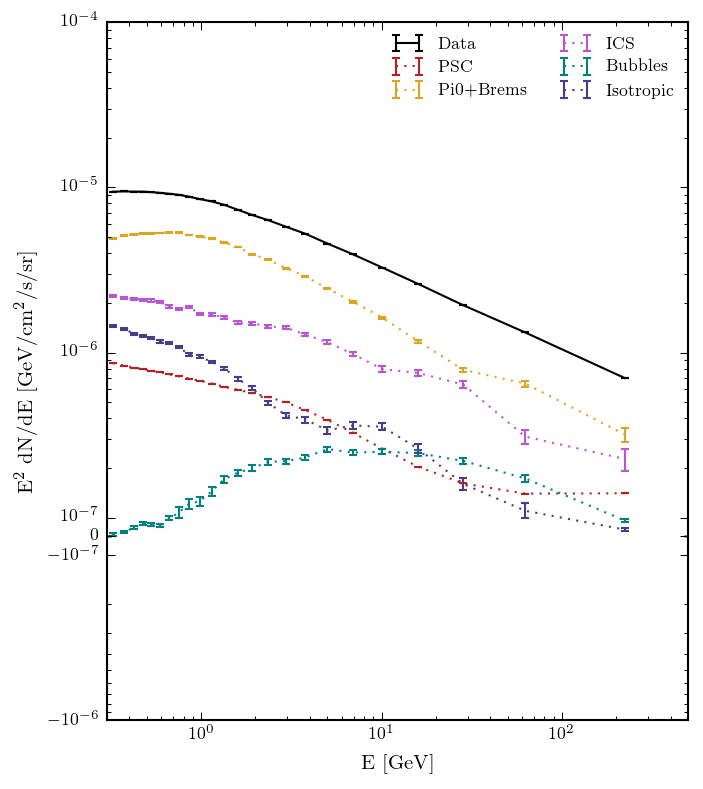

In [178]:
import Template
import Tools, healpy
reload(Tools)


#print np.array(A.m.matrix()).shape

#print A.templateList['DM'].valueError/A.templateList['DM'].value


plt.figure(figsize=(5,6))
def PlotComponent(name, mult=1):
    E, flux, stat = A.GetSpectrum(name)
    #if stat
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=name.replace('_','+'),
                     capthick=1, capsize=2, ls='-',c='k')
    else:
        plt.errorbar(E/1e3,E**2*flux*mult/1e3,E**2*stat.T/1e3*mult, label=name.replace('_','+'),capthick=1, capsize=2, ls=':' )
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    
PlotComponent('Data')    
PlotComponent('PSC')
PlotComponent('Pi0_Brems')

PlotComponent('ICS')

PlotComponent('Bubbles')
PlotComponent('Isotropic')
#PlotComponent('DM')
#PlotComponent('AqRift',mult=10)

linthresh=1e-7
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(-1e-6,1e-4)

plt.legend(frameon=False, fontsize=8,ncol=2)
#plt.ylim(1e-8,4e-4)
plt.xlim(.3,500)


#A.SaveSpectra('./mod_c/spec_mod_s_P8_PSF3.pickle') # 3FGL with ext XCO fitted 
A.SaveSpectra('./mod_c/spec_mod_s_42_40x40_noDM.pickle') # 3FGL with ext XCO fitted 



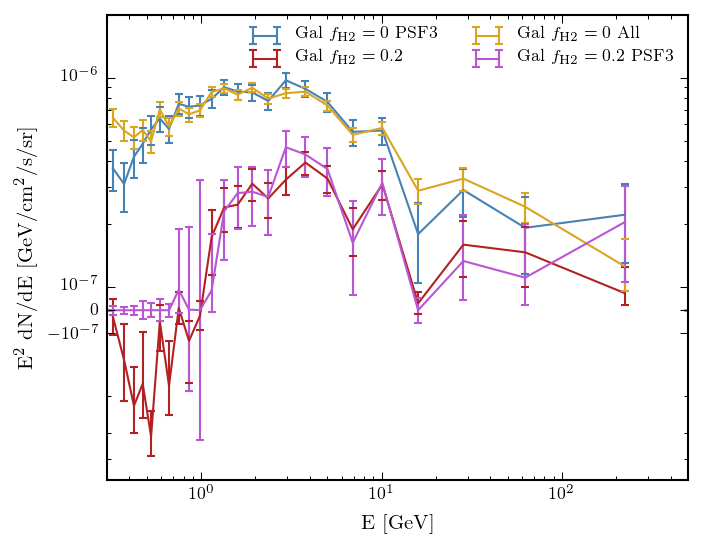

In [27]:
import pickle

plt.figure(figsize=(5,4))
def PlotComponentFromFile(name, filename,label='', linestyle='-'):
    E, flux, stat = pickle.load(open(filename))[name] # A.GetSpectrum(name)
    #if stat
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,
                     capthick=1, capsize=2, ls='-',c='k')
    else:
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,capthick=1, capsize=2, ls=linestyle )
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')

    
    
PlotComponentFromFile('DM','./mod_c/spec_mod_s_42_P8_PSF3.pickle', label=r'Gal $f_{\rm H2}=0$ PSF3', linestyle='-')
PlotComponentFromFile('DM','./mod_c/spec_mod_s_46_P8.pickle', label=r'Gal $f_{\rm H2}=0.2$', linestyle='-')

PlotComponentFromFile('DM','./mod_c/spec_mod_s_42_P8.pickle', label=r'Gal $f_{\rm H2}=0$ All', linestyle='-')
PlotComponentFromFile('DM','./mod_c/spec_mod_s_46_P8_PSF3.pickle', label=r'Gal $f_{\rm H2}=0.2$ PSF3', linestyle='-')





linthresh=1e-7
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(-5e-7,2e-6)
#plt.ylim(5e-8,2e-6)

plt.legend(frameon=False, fontsize=8,ncol=2)

plt.xlim(.3,500)

#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/PSF3_vs_All_GCE.pdf',bbox_inches='tight')


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app


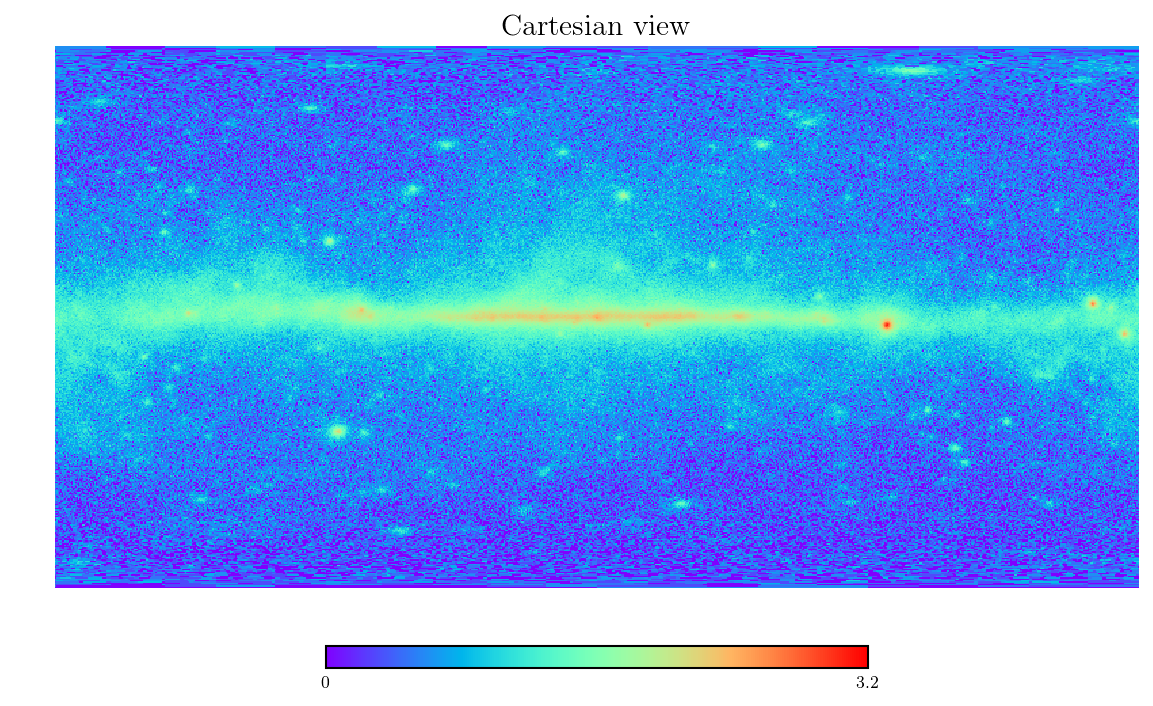

/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


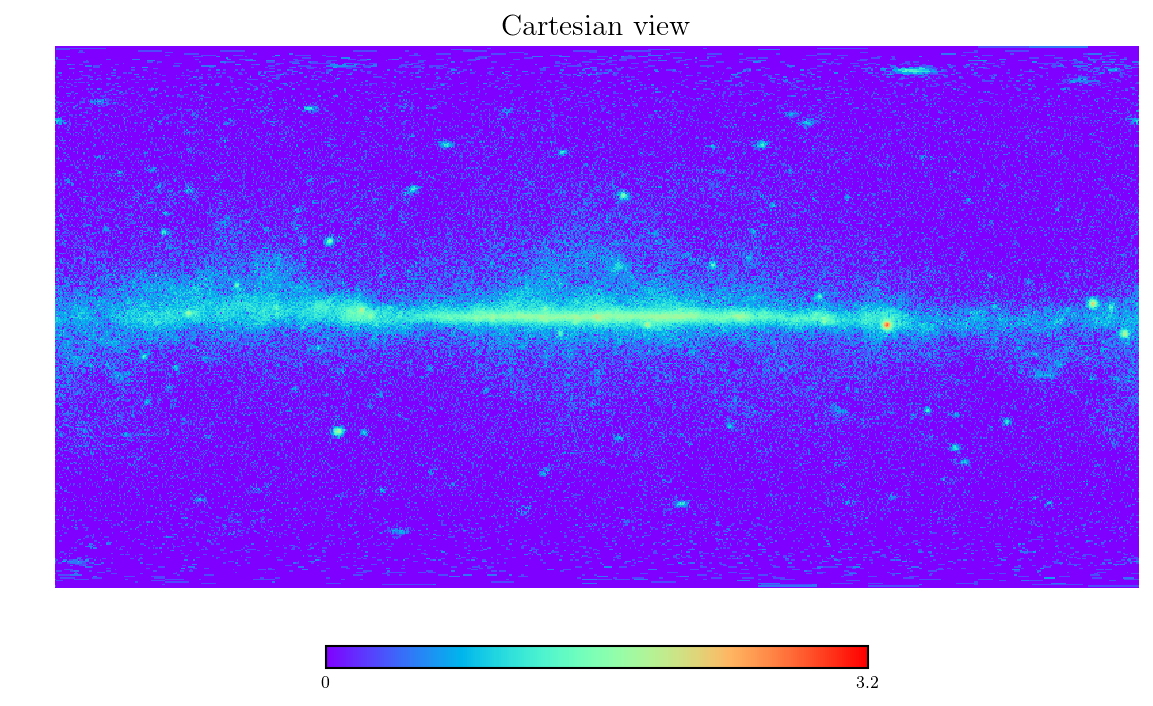

In [4]:
import healpy
healpy.cartview(np.log10(np.load('binned_photons_P8R2_CLEAN_V6_calore.npy')[0]), min=0, max=3.2, cmap='rainbow')
plt.show()
healpy.cartview(np.log10(np.load('binned_photons_P8R2_PSF3_CLEAN_V6_calore.npy')[0]), min=0, max=3.2, cmap='rainbow')

dm max dm at b=5 deg 2.51697838324e+19 2.32417159087e+18


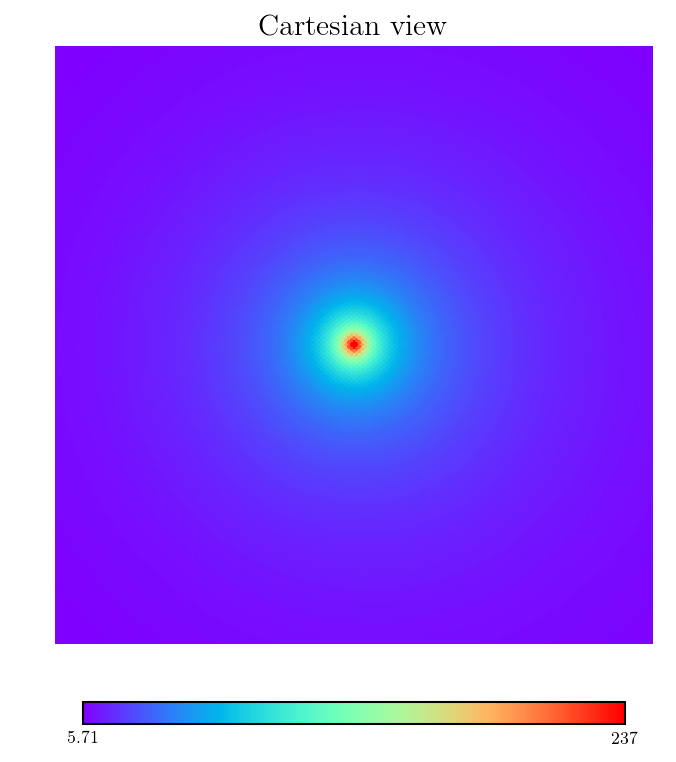

dm max dm at b=5 deg 2.4406460776e+21 9.69027413257e+18


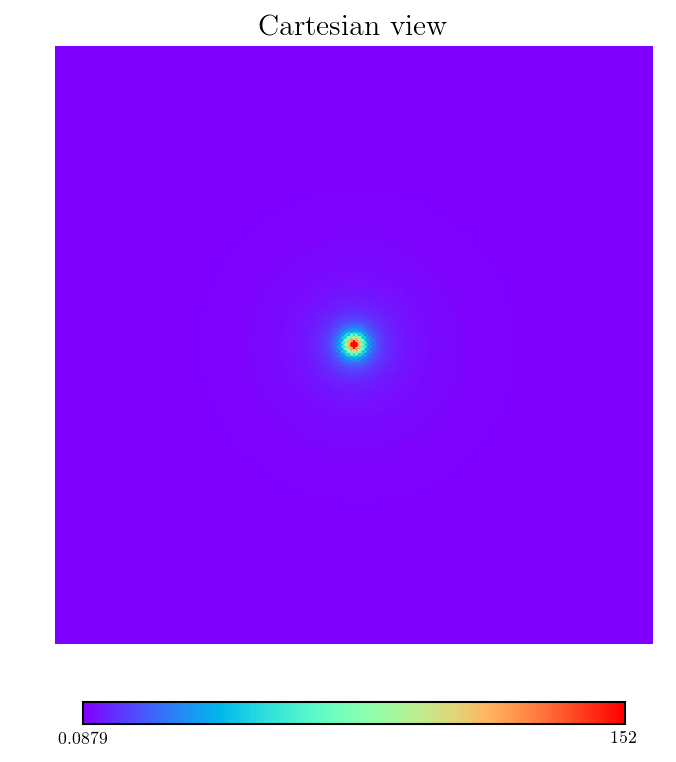

In [3]:


A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=.75, 
               r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)
import healpy
healpy.cartview(A.templateList['DM'].healpixCube[5], cmap='rainbow', latra=[-20,20], lonra=[-20,20])

plt.show()

A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
               r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)
import healpy
healpy.cartview(A.templateList['DM'].healpixCube[5], cmap='rainbow', latra=[-20,20], lonra=[-20,20])

(0.3, 500)

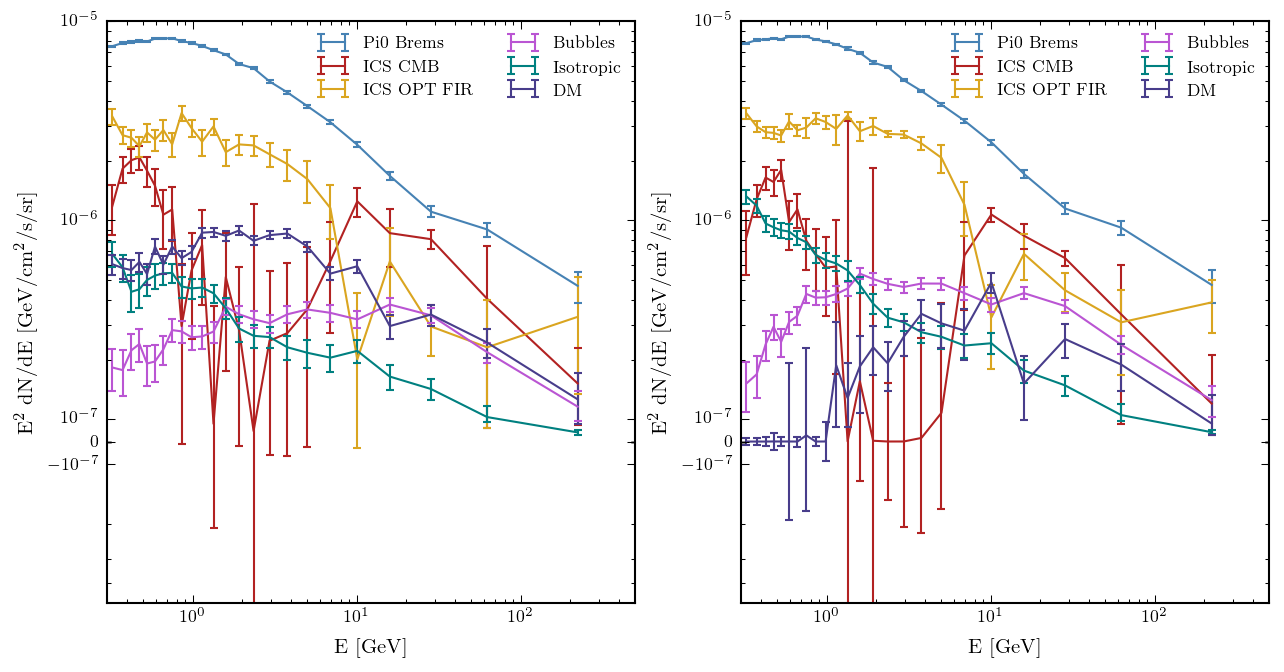

In [38]:
import pickle

plt.figure(figsize=(10,5))
def PlotComponentFromFile(name, filename,label='', linestyle='-'):
    E, flux, stat = pickle.load(open(filename))[name] # A.GetSpectrum(name)
    #if stat
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,
                     capthick=1, capsize=2, ls='-',c='k')
    else:
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,capthick=1, capsize=2, ls=linestyle )
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')

    


for component in ['Pi0_Brems', 'ICS_CMB', 'ICS_OPT_FIR', 'Bubbles', 'Isotropic','DM']:
    plt.subplot(121)
    PlotComponentFromFile(component,'./mod_c/spec_mod_s_42_P8_ics.pickle', label=component.replace('_'," "), linestyle='-')
    linthresh=1e-7
    plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
    plt.ylim(-5e-7,1e-5)
    plt.legend(frameon=False, fontsize=8,ncol=2)
    plt.xlim(.3,500)
    
    plt.subplot(122)
    PlotComponentFromFile(component,'./mod_c/spec_mod_s_46_P8_ics.pickle', label=component.replace('_'," "), linestyle='-')
    linthresh=1e-7
    plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
    plt.ylim(-5e-7,1e-5)
    plt.xlim(.3,500)



#linthresh=1e-7
#plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
#plt.ylim(-5e-7,2e-6)
#plt.ylim(5e-8,2e-6)

plt.legend(frameon=False, fontsize=8,ncol=2)

plt.xlim(.3,500)

#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/PSF3_vs_All_GCE.pdf',bbox_inches='tight')


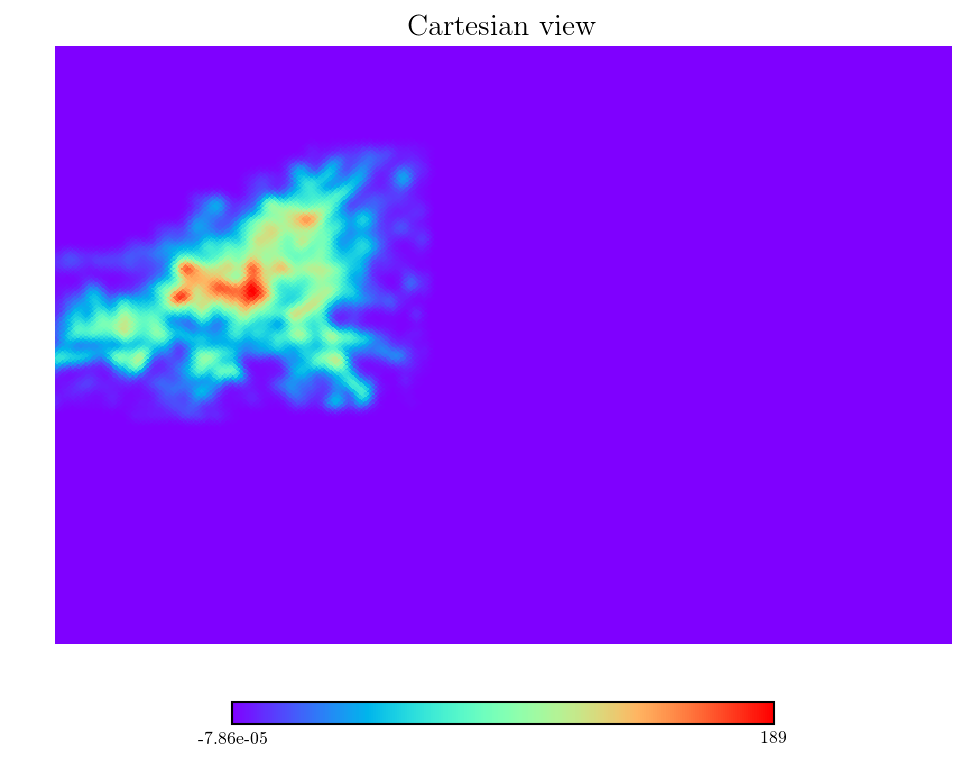

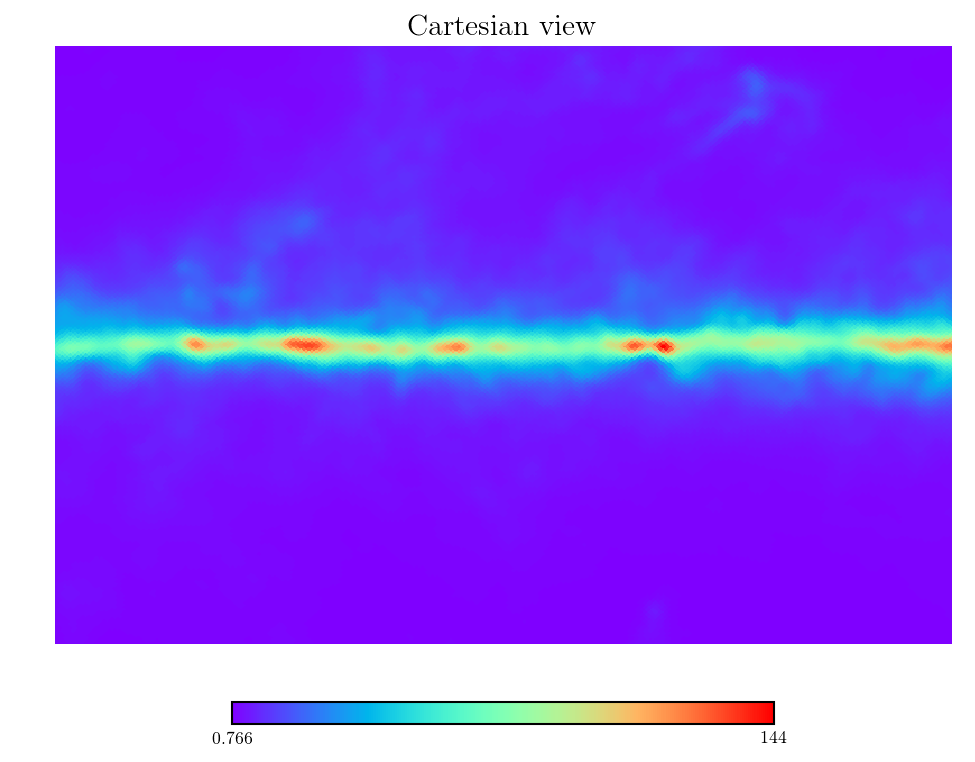

In [108]:
healpy.cartview(A.templateList['AqRift'].healpixCube[5], cmap='rainbow', latra=[-20,20], lonra=[-20,40])


healpy.cartview(A.templateList['Pi0_Brems'].healpixCube[5], cmap='rainbow', latra=[-20,20], lonra=[-20,40])


0.0

(0.3, 500)

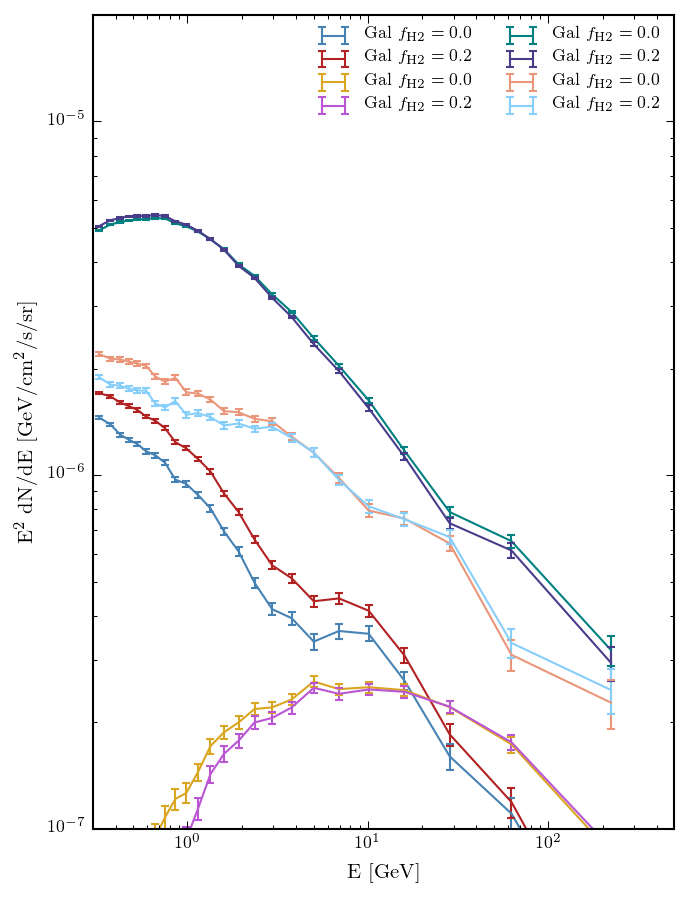

In [192]:
import pickle

plt.figure(figsize=(5,7))
def PlotComponentFromFile(name, filename,label='', linestyle='-'):
    E, flux, stat = pickle.load(open(filename))[name] # A.GetSpectrum(name)
    #if stat
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,
                     capthick=1, capsize=2, ls='-',c='k')
    else:
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,capthick=1, capsize=2, ls=linestyle )
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')

    
    
PlotComponentFromFile('Isotropic','./mod_c/spec_mod_s_42_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.0$', linestyle='-')
PlotComponentFromFile('Isotropic','./mod_c/spec_mod_s_46_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.2$', linestyle='-')
PlotComponentFromFile('Bubbles','./mod_c/spec_mod_s_42_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.0$', linestyle='-')
PlotComponentFromFile('Bubbles','./mod_c/spec_mod_s_46_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.2$', linestyle='-')
PlotComponentFromFile('Pi0_Brems','./mod_c/spec_mod_s_42_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.0$', linestyle='-')
PlotComponentFromFile('Pi0_Brems','./mod_c/spec_mod_s_46_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.2$', linestyle='-')
PlotComponentFromFile('ICS','./mod_c/spec_mod_s_42_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.0$', linestyle='-')
PlotComponentFromFile('ICS','./mod_c/spec_mod_s_46_40x40_noDM.pickle', label=r'Gal $f_{\rm H2}=0.2$', linestyle='-')


linthresh=1e-8
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(1e-7,2e-5)
#plt.ylim(5e-8,2e-6)

plt.legend(frameon=False, fontsize=8,ncol=2)

plt.xlim(.3,500)

#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/PSF3_vs_All_GCE.pdf',bbox_inches='tight')
